# Computing average Fst between populations in the Lehmann (Ag 3.1) cohort

In [1]:
import datetime
import functools
import intake
import allel
import matplotlib.pyplot as plt
import numpy as np
from dask_kubernetes import KubeCluster
from dask.distributed import Client
%matplotlib inline

## Data setup

In [2]:
cat = intake.open_catalog('https://malariagen.github.io/intake/gcs.yml')

In [3]:
df_sets = cat.ag3_1.sample_sets.read()
df_sets

/opt/conda/lib/python3.7/site-packages/dask/dataframe/utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


,sample_set,sample_count
0,1177-VO-ML-LEHMANN-MNF00004,648


In [4]:
df_samples = cat.ag3_1.samples(sample_set='1177-VO-ML-LEHMANN-MNF00004').read()
df_samples

,sample_id,partner_sample_id,contributor,country,location,year,month,latitude,longitude,sex_call
0,VBS00256-4651STDY7017184,GP97,Tovi Lehmann,Mali,Dallowere,2012,6,13.616,-7.037,F
1,VBS00257-4651STDY7017185,GP98,Tovi Lehmann,Mali,Dallowere,2012,6,13.616,-7.037,F
2,VBS00259-4651STDY7017186,GP100,Tovi Lehmann,Mali,Dallowere,2012,6,13.616,-7.037,F
3,VBS00262-4651STDY7017187,GP103,Tovi Lehmann,Mali,Dallowere,2012,6,13.616,-7.037,F
4,VBS00277-4651STDY7017189,GP118,Tovi Lehmann,Mali,Dallowere,2012,6,13.616,-7.037,F
...,...,...,...,...,...,...,...,...,...,...
643,VBS01998-4651STDY7017922,GP1839,Tovi Lehmann,Mali,Sokourani (Niono),2015,10,14.226,-5.975,F
644,VBS02000-4651STDY7017924,GP1841,Tovi Lehmann,Mali,Sokourani (Niono),2015,10,14.226,-5.975,F
645,VBS02001-4651STDY7017925,GP1842,Tovi Lehmann,Mali,Sokourani (Niono),2015,10,14.226,-5.975,F
646,VBS02002-4651STDY7017926,GP1843,Tovi Lehmann,Mali,Sokourani (Niono),2015,10,14.226,-5.975,F


In [5]:
df_species = cat.ag3_1.species_calls_20200422_aim(sample_set='1177-VO-ML-LEHMANN-MNF00004').read()
# call species - just use AIMs, should be fine
df_species.species_gambcolu_arabiensis.replace({'intermediate': 'intermediate_gambcolu_arabiensis'}, inplace=True)
df_species.species_gambiae_coluzzii.replace({'intermediate': 'intermediate_gambiae_coluzzii'}, inplace=True)
df_species['species'] = df_species.species_gambcolu_arabiensis.copy()
loc_gamb_colu = df_species.species_gambcolu_arabiensis == 'gamb_colu'
df_species.loc[loc_gamb_colu, 'species'] = df_species.species_gambiae_coluzzii[loc_gamb_colu]
df_species.groupby('species').size()

species
arabiensis                           29
coluzzii                            574
gambiae                              44
intermediate_gambcolu_arabiensis      1
dtype: int64

In [6]:
df_meta = df_samples.merge(df_species, on='sample_id', how='left', sort=False)
df_meta

,sample_id,partner_sample_id,contributor,country,location,year,month,latitude,longitude,sex_call,aim_fraction_colu,aim_fraction_arab,species_gambcolu_arabiensis,species_gambiae_coluzzii,species
0,VBS00256-4651STDY7017184,GP97,Tovi Lehmann,Mali,Dallowere,2012,6,13.616,-7.037,F,0.975,0.002,gamb_colu,coluzzii,coluzzii
1,VBS00257-4651STDY7017185,GP98,Tovi Lehmann,Mali,Dallowere,2012,6,13.616,-7.037,F,0.983,0.002,gamb_colu,coluzzii,coluzzii
2,VBS00259-4651STDY7017186,GP100,Tovi Lehmann,Mali,Dallowere,2012,6,13.616,-7.037,F,0.974,0.002,gamb_colu,coluzzii,coluzzii
3,VBS00262-4651STDY7017187,GP103,Tovi Lehmann,Mali,Dallowere,2012,6,13.616,-7.037,F,0.977,0.002,gamb_colu,coluzzii,coluzzii
4,VBS00277-4651STDY7017189,GP118,Tovi Lehmann,Mali,Dallowere,2012,6,13.616,-7.037,F,0.986,0.002,gamb_colu,coluzzii,coluzzii
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
643,VBS01998-4651STDY7017922,GP1839,Tovi Lehmann,Mali,Sokourani (Niono),2015,10,14.226,-5.975,F,0.972,0.002,gamb_colu,coluzzii,coluzzii
644,VBS02000-4651STDY7017924,GP1841,Tovi Lehmann,Mali,Sokourani (Niono),2015,10,14.226,-5.975,F,0.988,0.002,gamb_colu,coluzzii,coluzzii
645,VBS02001-4651STDY7017925,GP1842,Tovi Lehmann,Mali,Sokourani (Niono),2015,10,14.226,-5.975,F,0.985,0.002,gamb_colu,coluzzii,coluzzii
646,VBS02002-4651STDY7017926,GP1843,Tovi Lehmann,Mali,Sokourani (Niono),2015,10,14.226,-5.975,F,0.976,0.002,gamb_colu,coluzzii,coluzzii


In [7]:
# add in a pseudo collection date for date range filtering
collection_date = df_meta.apply(lambda rec: datetime.datetime(rec['year'], rec['month'], 15),
                                axis=1)
df_meta['date'] = collection_date
df_meta

,sample_id,partner_sample_id,contributor,country,location,year,month,latitude,longitude,sex_call,aim_fraction_colu,aim_fraction_arab,species_gambcolu_arabiensis,species_gambiae_coluzzii,species,date
0,VBS00256-4651STDY7017184,GP97,Tovi Lehmann,Mali,Dallowere,2012,6,13.616,-7.037,F,0.975,0.002,gamb_colu,coluzzii,coluzzii,2012-06-15
1,VBS00257-4651STDY7017185,GP98,Tovi Lehmann,Mali,Dallowere,2012,6,13.616,-7.037,F,0.983,0.002,gamb_colu,coluzzii,coluzzii,2012-06-15
2,VBS00259-4651STDY7017186,GP100,Tovi Lehmann,Mali,Dallowere,2012,6,13.616,-7.037,F,0.974,0.002,gamb_colu,coluzzii,coluzzii,2012-06-15
3,VBS00262-4651STDY7017187,GP103,Tovi Lehmann,Mali,Dallowere,2012,6,13.616,-7.037,F,0.977,0.002,gamb_colu,coluzzii,coluzzii,2012-06-15
4,VBS00277-4651STDY7017189,GP118,Tovi Lehmann,Mali,Dallowere,2012,6,13.616,-7.037,F,0.986,0.002,gamb_colu,coluzzii,coluzzii,2012-06-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
643,VBS01998-4651STDY7017922,GP1839,Tovi Lehmann,Mali,Sokourani (Niono),2015,10,14.226,-5.975,F,0.972,0.002,gamb_colu,coluzzii,coluzzii,2015-10-15
644,VBS02000-4651STDY7017924,GP1841,Tovi Lehmann,Mali,Sokourani (Niono),2015,10,14.226,-5.975,F,0.988,0.002,gamb_colu,coluzzii,coluzzii,2015-10-15
645,VBS02001-4651STDY7017925,GP1842,Tovi Lehmann,Mali,Sokourani (Niono),2015,10,14.226,-5.975,F,0.985,0.002,gamb_colu,coluzzii,coluzzii,2015-10-15
646,VBS02002-4651STDY7017926,GP1843,Tovi Lehmann,Mali,Sokourani (Niono),2015,10,14.226,-5.975,F,0.976,0.002,gamb_colu,coluzzii,coluzzii,2015-10-15


In [8]:
# slight change to population codes, use {site}{species}{year}{season}
pop_queries = { 
    'DC12A' : {
        'location': 'Dallowere', 'species' : 'coluzzii', 
        'since': '2012-01-01', 'until': '2013-01-01'},
    'DC14EW': {
        'location': 'Dallowere', 'species' : 'coluzzii', 
        'since': '2014-05-01', 'until': '2014-08-01'},
    'DC14LW': {
        'location': 'Dallowere', 'species' : 'coluzzii', 
        'since': '2014-08-01', 'until': '2014-11-01'},
    'DC15LD': {
        'location': 'Dallowere', 'species' : 'coluzzii', 
        'since': '2015-02-01', 'until': '2015-05-01'},
    'DC15EW': {
        'location': 'Dallowere', 'species' : 'coluzzii', 
        'since': '2015-05-01', 'until': '2015-08-01'},
    'DC15LW': {
        'location': 'Dallowere', 'species' : 'coluzzii', 
        'since': '2015-08-01', 'until': '2015-11-01'},
    'SC12A' : {
        'location': 'Sokourani (Niono)', 'species' : 'coluzzii', 
        'since': '2012-01-01', 'until': '2013-01-01'},
    'SC13LD': {
        'location': 'Sokourani (Niono)', 'species' : 'coluzzii', 
        'since': '2013-02-01', 'until': '2013-05-01'},
    'SC14LD': {
        'location': 'Sokourani (Niono)', 'species' : 'coluzzii', 
        'since': '2014-02-01', 'until': '2014-05-01'},
    'SC15LD': {
        'location': 'Sokourani (Niono)', 'species' : 'coluzzii', 
        'since': '2015-02-01', 'until': '2015-05-01'},
    'SC15LW': {
        'location': 'Sokourani (Niono)', 'species' : 'coluzzii', 
        'since': '2015-08-01', 'until': '2015-11-01'},
}

In [9]:
pop_idxs = dict()
for k, v in pop_queries.items():
    loc = (
        (df_meta.location == v['location']) & 
        (df_meta.species == v['species']) & 
        (df_meta.date >= v['since']) & 
        (df_meta.date < v['until'])
    )
    idx = df_meta[loc].index.values
    pop_idxs[k] = idx
pop_idxs

{'DC12A': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 11, 14, 17, 18, 19, 20, 21,
        22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33]),
 'DC14EW': array([34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97]),
 'DC14LW': array([ 98, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 113, 115,
        116, 118, 119, 122, 123, 125, 126, 127, 128, 129, 130, 131, 134,
        135, 136, 138, 139, 142, 144, 146, 149, 151, 152, 153, 155, 156,
        157, 158, 160, 163, 165, 166, 167, 170, 172, 175, 176, 177, 179,
        181, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192]),
 'DC15LD': array([193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205,
        206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218,
        219, 220, 221, 222, 223, 224, 

In [10]:
callset_sites = cat.ag3.snp_sites.to_zarr()
callset_sites

<zarr.hierarchy.Group '/' read-only>

In [11]:
callset_filters_gamb_colu = cat.ag3.site_filters_dt_20200416_gamb_colu.to_zarr()
callset_filters_gamb_colu

<zarr.hierarchy.Group '/' read-only>

In [12]:
callset_genotypes = cat.ag3_1.snp_genotypes(sample_set='1177-VO-ML-LEHMANN-MNF00004').to_zarr()
callset_genotypes

<zarr.hierarchy.Group '/' read-only>

## Allele counting

In [13]:
cluster = KubeCluster(n_workers=20)
client = Client(cluster)
client

distributed.scheduler - INFO - Clear task state
distributed.scheduler - INFO -   Scheduler at:  tcp://10.35.63.198:44697
distributed.scheduler - INFO -   dashboard at:                     :8787
distributed.scheduler - INFO - Receive client connection: Client-c9d1f090-b61d-11ea-8061-da7ccd997000
distributed.core - INFO - Starting established connection


Client Scheduler: tcp://10.35.63.198:44697 Dashboard: /user/alimanfoo@googlemail.com/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [14]:
# N.B., use functools.lru_cache here for a couple of functions to avoid
# reloading or recomputing the same thing multiple times.


@functools.lru_cache(maxsize=None)
def load_pos(seq_id):
#     print('load_pos', seq_id)
    pos = allel.SortedIndex(callset_sites[seq_id]['variants']['POS'])
    return pos


@functools.lru_cache(maxsize=None)
def load_mask(seq_id, max_miss=.1):
#     print('load_mask', seq_id)
    
    # site filters
    filter_pass = callset_filters_gamb_colu[seq_id]['variants']['filter_pass'][:]
    
    # missingness
    gt = allel.GenotypeDaskArray(callset_genotypes[seq_id]['calldata']['GT'])
    n_miss = gt.count_missing(axis=1).compute()
    n_samples = gt.shape[1]
    low_miss = (n_miss / n_samples) < max_miss
    
    # combine
    mask = filter_pass & low_miss
    
    return mask


def count_alleles(pop, region, max_miss=.1):
#     print('count_alleles', pop, region, max_miss)
    
    # unpack region
    seq_id, region_start, region_stop = region
    
    # setup variables
    pos = load_pos(seq_id)
    gt = allel.GenotypeDaskArray(callset_genotypes[seq_id]['calldata']['GT'])
    
    # apply mask
    mask = load_mask(seq_id, max_miss)
    pos_mask = pos[mask]
    gt_mask = gt[mask]

    # subset to population
    pop_idx = pop_idxs[pop]
    gt_pop = gt_mask.take(pop_idx, axis=1)
    
    # restrict to genome region
    loc_region = pos_mask.locate_range(region_start, region_stop)
    pos_region = pos_mask[loc_region]
    gt_pop_region = gt_pop[loc_region]
        
    # perform allele count
    ac = gt_pop_region.count_alleles(max_allele=3).compute()
    
    return pos_region, ac


In [15]:
region_3L_free = '3L', 15_000_000, 41_000_000
region_3R_free = '3R', 1_000_000, 37_000_000

In [16]:
pops = list(pop_idxs.keys())
pops

['DC12A',
 'DC14EW',
 'DC14LW',
 'DC15LD',
 'DC15EW',
 'DC15LW',
 'SC12A',
 'SC13LD',
 'SC14LD',
 'SC15LD',
 'SC15LW']

In [17]:
count_alleles(pops[0], region_3L_free)

distributed.scheduler - INFO - Register tcp://10.33.135.5:44151
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.33.135.5:44151
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.33.119.8:38901
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.33.119.8:38901
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.33.124.6:42925
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.33.124.6:42925
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.33.125.6:44333
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.33.125.6:44333
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.33.123.6:40397
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.33.123.6:40397
distributed.c

(<SortedIndex shape=(18889674,) dtype=int32>
 [15000000, 15000001, 15000002, 15000003, 15000004, ..., 40999996, 40999997, 40999998, 40999999, 41000000],
 <AlleleCountsArray shape=(18889674, 4) dtype=int32>
  7 49  0  0
 56  0  0  0
 55  0  0  1
 ...
 56  0  0  0
 54  2  0  0
 52  4  0  0)

In [18]:
count_alleles(pops[2], region_3R_free)

(<SortedIndex shape=(26290001,) dtype=int32>
 [1000000, 1000001, 1000002, 1000003, 1000004, ..., 36999996, 36999997, 36999998, 36999999, 37000000],
 <AlleleCountsArray shape=(26290001, 4) dtype=int32>
 126   0   0   0
 126   0   0   0
 126   0   0   0
 ...
 126   0   0   0
 125   1   0   0
 125   1   0   0)

## Fst computation

In [19]:
@functools.lru_cache(maxsize=None)
def compute_fst(pop1, pop2, *, blen=20_000, seg='union', biallelic=True):
#    print('compute_fst', pop1, pop2, blen)
    
    # obtain allele counts
    _, ac1_3L = count_alleles(pop1, region_3L_free)
    _, ac1_3R = count_alleles(pop1, region_3R_free)
    ac1 = ac1_3L.concatenate(ac1_3R)
    _, ac2_3L = count_alleles(pop2, region_3L_free)
    _, ac2_3R = count_alleles(pop2, region_3R_free)
    ac2 = ac2_3L.concatenate(ac2_3R)
    ac = ac1 + ac2
    
    if seg == 'union':
        # locate sites segregating in the union of both populations
        loc_seg = ac.is_segregating()
    elif seg == 'both':
        # locate sites segregating within both populations
        loc_seg = ac1.is_segregating() & ac2.is_segregating()
    elif seg == 'either':
        # locate sites segregating in either population
        loc_seg = ac1.is_segregating() | ac2.is_segregating()
    else:
        raise ValueError
    if biallelic:
        loc_seg = loc_seg & ac.is_biallelic()
    n_sites = np.count_nonzero(loc_seg)
    ac1_seg = ac1[loc_seg]
    ac2_seg = ac2[loc_seg]
    
    # compute fst
    fst, se, vb, vj = allel.average_hudson_fst(ac1_seg, ac2_seg, blen)
    
    return fst, se, vb, n_sites

In [27]:
def print_fst(pop1, pop2, *, blen=10_000, seg='union', biallelic=True):
    fst, se, _, n_sites = compute_fst(pop1, pop2, blen=blen, seg=seg, biallelic=biallelic)
    print(f'{pop1} vs {pop2} [seg {seg}, biallelic {biallelic}; {n_sites:,} sites]: {fst:.7f} +/- {se:.7f}')
    

In [28]:
print_fst(pops[0], pops[1], seg='union', biallelic=True)

DC12A vs DC14EW [seg union, biallelic True; 9,334,531 sites]: -0.0000089 +/- 0.0000277


In [29]:
print_fst(pops[0], pops[1], seg='union', biallelic=False)

DC12A vs DC14EW [seg union, biallelic False; 10,387,025 sites]: 0.0000024 +/- 0.0000260


In [30]:
print_fst(pops[0], pops[1], seg='either', biallelic=True)

DC12A vs DC14EW [seg either, biallelic True; 9,334,531 sites]: -0.0000089 +/- 0.0000277


In [31]:
print_fst(pops[0], pops[1], seg='either', biallelic=False)

DC12A vs DC14EW [seg either, biallelic False; 10,387,025 sites]: 0.0000024 +/- 0.0000260


In [32]:
print_fst(pops[0], pops[1], seg='both', biallelic=True)

DC12A vs DC14EW [seg both, biallelic True; 3,759,360 sites]: -0.0013322 +/- 0.0000311


In [33]:
print_fst(pops[0], pops[1], seg='both', biallelic=False)

DC12A vs DC14EW [seg both, biallelic False; 4,594,396 sites]: -0.0011978 +/- 0.0000304


In [34]:
print_fst(pops[1], pops[2], seg='union', biallelic=True)

DC14EW vs DC14LW [seg union, biallelic True; 10,309,733 sites]: 0.0001234 +/- 0.0000176


In [39]:
print_fst(pops[1], pops[2], seg='union', biallelic=False)

DC14EW vs DC14LW [seg union, biallelic False; 11,627,062 sites]: 0.0001244 +/- 0.0000169


In [40]:
print_fst(pops[1], pops[2], seg='either', biallelic=True)

DC14EW vs DC14LW [seg either, biallelic True; 10,309,733 sites]: 0.0001234 +/- 0.0000176


In [41]:
print_fst(pops[1], pops[2], seg='either', biallelic=False)

DC14EW vs DC14LW [seg either, biallelic False; 11,627,062 sites]: 0.0001244 +/- 0.0000169


In [42]:
print_fst(pops[1], pops[2], seg='both', biallelic=True)

DC14EW vs DC14LW [seg both, biallelic True; 4,692,908 sites]: -0.0004438 +/- 0.0000212


In [43]:
print_fst(pops[1], pops[2], seg='both', biallelic=False)

DC14EW vs DC14LW [seg both, biallelic False; 5,825,161 sites]: -0.0003761 +/- 0.0000189


In [44]:
print_fst(pops[1], pops[2])

DC14EW vs DC14LW [seg union, biallelic True; 10,309,733 sites]: 0.0001234 +/- 0.0000176


In [45]:
print_fst(pops[2], pops[3])

DC14LW vs DC15LD [seg union, biallelic True; 9,577,559 sites]: 0.0000716 +/- 0.0000240


In [46]:
print_fst(pops[3], pops[4])

DC15LD vs DC15EW [seg union, biallelic True; 8,998,469 sites]: 0.0000736 +/- 0.0000230


In [47]:
print_fst(pops[4], pops[5])

DC15EW vs DC15LW [seg union, biallelic True; 10,027,620 sites]: 0.0000195 +/- 0.0000179


In [48]:
print_fst(pops[1], pops[2])

DC14EW vs DC14LW [seg union, biallelic True; 10,309,733 sites]: 0.0001234 +/- 0.0000176


In [49]:
print_fst(pops[1], pops[3])

DC14EW vs DC15LD [seg union, biallelic True; 9,806,636 sites]: 0.0000627 +/- 0.0000200


In [50]:
print_fst(pops[1], pops[4])

DC14EW vs DC15EW [seg union, biallelic True; 9,814,143 sites]: 0.0000774 +/- 0.0000192


In [51]:
print_fst(pops[1], pops[5])

DC14EW vs DC15LW [seg union, biallelic True; 10,694,026 sites]: 0.0000559 +/- 0.0000156


## Genome scan Fst plots

In [83]:
@functools.lru_cache(maxsize=None)
def scan_fst(seq_id, pop1, pop2, *, blen=20_000, seg='union', biallelic=True):
    
    # whole chromosome arm
    region = seq_id, None, None

    # obtain allele counts
    pos, ac1 = count_alleles(pop1, region)
    _, ac2 = count_alleles(pop2, region)
    ac = ac1 + ac2
    
    if seg == 'union':
        # locate sites segregating in the union of both populations
        loc_seg = ac.is_segregating()
    elif seg == 'both':
        # locate sites segregating within both populations
        loc_seg = ac1.is_segregating() & ac2.is_segregating()
    elif seg == 'either':
        # locate sites segregating in either population
        loc_seg = ac1.is_segregating() | ac2.is_segregating()
    else:
        raise ValueError
    if biallelic:
        loc_seg = loc_seg & ac.is_biallelic()
    n_sites = np.count_nonzero(loc_seg)
    ac1_seg = ac1[loc_seg]
    ac2_seg = ac2[loc_seg]
    pos_seg = pos[loc_seg]
    
    # compute fst
    fst, se, vb, vj = allel.average_hudson_fst(ac1_seg, ac2_seg, blen)
    
    # compute block midpoints
    midpoints = allel.moving_statistic(pos_seg, statistic=np.median, size=blen)
    
    return fst, se, vb, midpoints, n_sites

In [84]:
def plot_scan_fst(seq_id, pop1, pop2,  *, blen=20_000, seg='union', biallelic=True):
    fst, se, y, x, n_sites = scan_fst(seq_id, pop1, pop2, blen=blen, seg=seg, biallelic=biallelic)
    fig, ax = plt.subplots(figsize=(9, 2), dpi=120)
    ax.plot(x/1e6, y, marker='o', mfc='none', linestyle=' ')
    ax.set_xlabel(f'Chromosome arm {seq_id} position (Mbp)')
    ax.set_ylabel('$F_{ST}$')
    ax.set_title(f'{pop1} vs {pop2}')


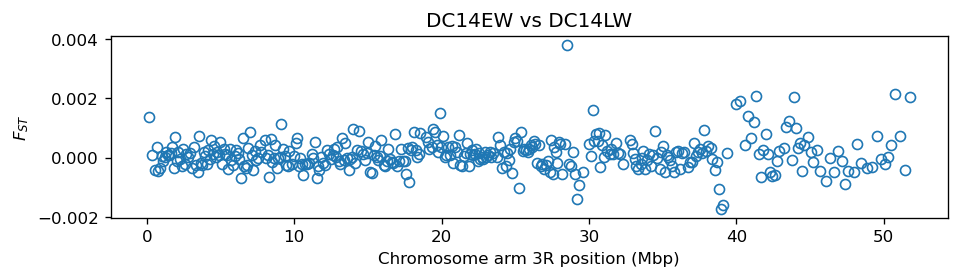

In [85]:
plot_scan_fst('3R', pops[1], pops[2])

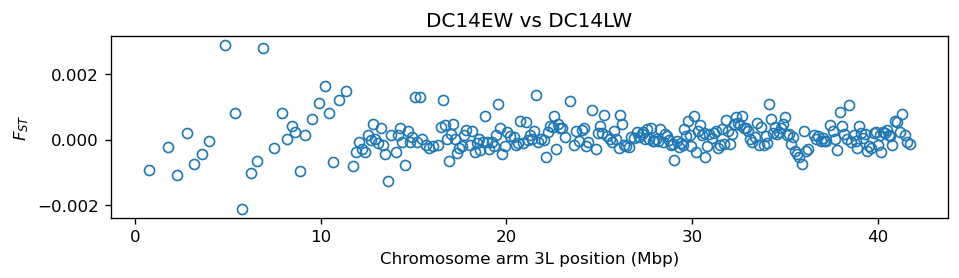

In [86]:
plot_scan_fst('3L', pops[1], pops[2])